In [78]:
import pandas as pd
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import json

sns.set_style("darkgrid")

FILTER_RAW_DATASET = False
GENERATE_NETWORK = False

NETWORK_FILE = "movie_network.json"

[Get dataset here](https://nijianmo.github.io/amazon/index.html)

In [76]:
def save_graph(graph_file, G):
    data = nx.readwrite.json_graph.node_link_data(G)
    with open(graph_file, "w") as f:
        json.dump(data, f)

def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)

### Filtering

In [22]:
def load_and_filter_raw_dataset(raw_file, filtered_file):
    df = pd.read_json(raw_file, lines=True)
    df = df.loc[df['verified']]
    df.drop(['reviewTime', 'image', 'vote', 'style', 'verified'], inplace=True, axis=1)
    df.to_csv(filtered_file, index=False)
    return df

In [23]:
RAW_DATA_FILE = 'Movies_and_TV_5.json'
FILTERED_DATA_FILE = 'tv.csv'

if FILTER_RAW_DATASET:
    df = load_and_filter_raw_dataset(RAW_DATA_FILE, FILTERED_DATA_FILE)
else:
    df = pd.read_csv(FILTERED_DATA_FILE)

df.head()

,overall,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,A2M1CU2IRZG0K9,0005089549,Terri,So sorry I didn't purchase this years ago when...,Amazing!,1352419200
1,5,AFTUJYISOFHY6,0005089549,Melissa D. Abercrombie,Believe me when I tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200
2,5,A3JVF9Y53BEOGC,000503860X,Anthony Thompson,"I have seen X live many times, both in the ear...",A great document of a great band,1114041600
3,5,A12VPEOEZS1KTC,000503860X,JadeRain,"I was so excited for this! Finally, a live co...",YES!! X LIVE!!,1112745600
4,5,ATLZNVLYKP9AZ,000503860X,T. Fisher,X is one of the best punk bands ever. I don't ...,X have still got it,1291334400


### Network

In [24]:
# grouped = df.groupby('asin')['reviewerID'].unique()
# for movie_id, reviewers in grouped.items():
#     if len(set(reviewers)) < 5:
#         print(f"Movie {movie_id} has only {len(set(reviewers))} unique reviewers.")
#         break

In [41]:
def filter_reviews(df, movie_threshold=10, review_threshold=10):
    prev_shape = (0, 0)
    current_shape = df.shape

    while current_shape != prev_shape:
        prev_shape = current_shape
        review_counts = df.groupby('asin')['reviewerID'].nunique()
        valid_movies = review_counts[review_counts >= review_threshold].index
        df = df[df['asin'].isin(valid_movies)]

        reviewer_counts = df.groupby('reviewerID')['asin'].nunique()
        valid_reviewers = reviewer_counts[reviewer_counts >= movie_threshold].index
        df = df[df['reviewerID'].isin(valid_reviewers)]

        current_shape = df.shape

    return df

filtered_df = filter_reviews(df)

In [38]:
reviewer_counts = df.groupby('reviewerID')['asin'].nunique()
len(reviewer_counts[reviewer_counts > 500])

4

In [56]:
filtered_df["asin"].nunique()

20244

In [49]:
def generate_edge_list():
    grouped = filtered_df.groupby('reviewerID')['asin'].unique()
    edges = Counter()
    for reviewers in tqdm(grouped.values, desc="Reviewer"):
        for pair in combinations(reviewers, 2):
            edges[pair] += 1
    return [(a, b, count) for (a, b), count in edges.items()]

# def generate_edge_list():
#     df = filtered_df[['asin','reviewerID']].drop_duplicates()
#     pairs = df.merge(df, on='asin')
#     pairs = pairs[pairs.reviewerID_x < pairs.reviewerID_y]
#     counts = (
#         pairs
#         .groupby(['reviewerID_x','reviewerID_y'])
#         .size()
#         .reset_index(name='count')
#     )
#     return [tuple(x) for x in counts.values]

In [50]:
# edgelist = generate_edge_list()
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 53141/53141 [00:11<00:00, 4450.99it/s]


11895557

In [43]:
thresholds = [4,5,7,10,15]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in edgelist if w > t]
    print(f"Edges with weight > {t}: {len(weighted_edges)}")

Edges with weight > 4: 624551
Edges with weight > 5: 262524
Edges with weight > 7: 69450
Edges with weight > 10: 15907
Edges with weight > 15: 2618


### Graph

In [ ]:
WEIGHT_THRESHOLD = 5
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

284681

In [ ]:
# G = nx.Graph()
# G.add_weighted_edges_from(weighted_movie_edge)

In [ ]:
# save_graph(NETWORK_FILE, G)

In [ ]:
G = load_graph(NETWORK_FILE)

In [ ]:
len(G.nodes()), len(G.edges())

(12049, 284564)

In [64]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

47.23445929122749

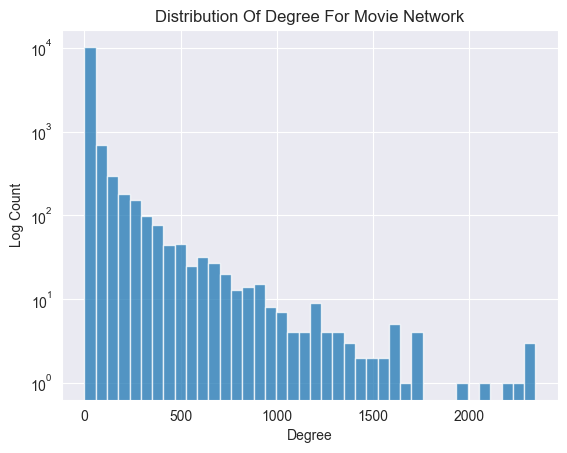

In [68]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75);

### Community detection

In [71]:

def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [69]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [70]:
communities = louvain_partitions(G)
len(communities)

760

In [73]:
modularity(G, communities) 

0.4845974754516164